# Initial visualizations of your data

This notebook is meant to let you quickly look at your post-manually sorted data

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pickle
import os
import sys
from ephys import core, events, rasters
from neuraltda import topology
import glob
import string
%pylab inline
reload(topology)

Populating the interactive namespace from numpy and matplotlib


<module 'neuraltda.topology' from '/home/brad/code/NeuralTDA/neuraltda/topology.pyc'>

## Load the data

Set 'block_path' to the path of the folder containing your post-manually sorted data

In [2]:

block_path = '/mnt/cube/btheilma/experiments/B1235/phy051316/Pen01_Lft_AP200_ML800__Site01_Z2200__B1235_cat_P01_S01_1/'
clusters   = core.load_clusters(block_path)
trials     = events.load_trials(block_path)
fs         = core.load_fs(block_path)
rec        = 0 

In [3]:
topofolder = '/mnt/cube/btheilma/experiments/B1235/phy051316/Pen01_Lft_AP200_ML800__Site01_Z2200__B1235_cat_P01_S01_1/topology/bht060816/B1235_cat_P01_S01_1-good_50ms_stim/'
persistence_files = sorted(glob.glob(os.path.join(topofolder, '*.pkl')))


## Plot rasters of each trial from each Good unit for all stims



In [ ]:
bird=1235
windt = 50
prd = 'stim'
figsize = (22, 20)
fig, axs = plt.subplots(4, 4, figsize=figsize)

for stimind in range(len(persistence_files)):
    tf = persistence_files[stimind]
    tfilepath, tfilename = os.path.split(tf)
    stimname = list(string.ascii_lowercase)[stimind]
    pdata = pickle.load(open(tf, 'r'))
    #print(tf)

    betti=1
    ax = axs.flatten()[stimind]
    upper=0
    for trial in range(20):
        
        trialdata = pdata['{}'.format(str(trial))]
        betti1 = np.zeros([len(trialdata), 2])
        for ind, filt in enumerate(trialdata):
            betti1[ind, 0] = filt[0]*windt/1000.
            try: 
                betti1[ind, 1] = filt[1][betti]
            except IndexError:
                betti1[ind, 1] = 0
            
        upper = max([upper, max(betti1[:, 1])])
        #print(upper)
        
        #ax.set_xlim(0, 8)
        #ax.set_ylim(0, 10)
        pltcolor='b'
#        if stimname in ['stimA', 'stimB', 'stimC', 'stimD']:
#            pltcolor = 'r'
        ax.plot(betti1[:, 0], betti1[:,1], pltcolor, lw=2)
        ax.set_title('Stimulus: {}'.format(stimname))
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('First Betti Number')
        ax.set_ylim([0, upper+1])
plt.savefig('/home/brad/B{}_betti{}_timedep_{}ms_{}.png'.format(bird, betti, windt, prd))

In [ ]:
topofolder1 = '/mnt/cube/btheilma/experiments/B1235/phy051316/Pen01_Lft_AP200_ML800__Site01_Z2200__B1235_cat_P01_S01_1/topology/bht060716/B1235_cat_P01_S01_1-good_50ms_stim/'
topofolder2 = '/mnt/cube/btheilma/experiments/B1235/phy051316/Pen01_Lft_AP200_ML800__Site01_Z2200__B1235_cat_P01_S01_1/topology/bht060816/B1235_cat_P01_S01_1-good_50ms_stim/'
persistence_files1 = glob.glob(os.path.join(topofolder1, '*.pkl'))
persistence_files2 = glob.glob(os.path.join(topofolder2, '*.pkl'))
tfile1 = persistence_files1[0]
tfile2 = persistence_files2[0]
print(persistence_files1)
print(persistence_files2)

In [ ]:
betti1

## See a cell / stim combo that looked interesting?  Plot it here!

In [ ]:
from scipy.interpolate import interp1d
bird=1235
windt = 50
prd = 'prestim'
ntrials = 20
t = np.linspace(0, 7, num=1000)
betticurves = np.zeros((ntrials, 1000))
bettiStimspline=[]
figsize = (22, 20)
fig, axs = plt.subplots(4, 4, figsize=figsize)


for stimind in range(len(persistence_files)):
    tf = persistence_files[stimind]
    tfilepath, tfilename = os.path.split(tf)
    stimname = list(string.ascii_lowercase)[stimind]
    pdata = pickle.load(open(tf, 'r'))
    #print(tf)

    betti=2
    upper=0
    bettiTrialspline=[]
    ax = axs.flatten()[stimind]
    for trial in range(20):
        
        trialdata = pdata['{}'.format(str(trial))]
        betti1 = np.zeros([len(trialdata), 2])
        for ind, filt in enumerate(trialdata):
            betti1[ind, 0] = filt[0]*windt/1000.
            try: 
                betti1[ind, 1] = filt[1][betti]
            except IndexError:
                betti1[ind, 1] = 0
                
        bettifunc = interp1d(betti1[:, 0], betti1[:, 1], kind='zero', bounds_error=False, fill_value=(betti1[0, 1], betti1[-1, 1]))
        betticurve = bettifunc(t)
        betticurves[trial, :] = betticurve
    avgbetticurve = np.mean(betticurves, axis=0)
    ax.plot(t, avgbetticurve, lw=2)
    ax.set_title('Stimulus: {}'.format(stimname))
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('First Betti Number')
   

In [4]:
from scipy.interpolate import interp1d
bird=1235
windt = 50
prd = 'prestim'
ntrials = 20
t = np.linspace(0, 7, num=1000)
max_betti=4
betticurves = np.zeros((max_betti, ntrials, 1000))
bettiStimspline=[]


stimind = 15
tf = persistence_files[stimind]
tfilepath, tfilename = os.path.split(tf)
stimname = list(string.ascii_lowercase)[stimind]
pdata = pickle.load(open(tf, 'r'))

for trial in range(20):
        
    trialdata = pdata['{}'.format(str(trial))]
    for betti_num in range(max_betti):
        betti1 = np.zeros([len(trialdata), 2])
        for ind, filt in enumerate(trialdata):
            betti1[ind, 0] = filt[0]*windt/1000.
            try: 
                betti1[ind, 1] = filt[1][betti_num]
            except IndexError:
                betti1[ind, 1] = 0
                
        bettifunc = interp1d(betti1[:, 0], betti1[:, 1], kind='zero', bounds_error=False, fill_value=(betti1[0, 1], betti1[-1, 1]))
        betticurve = bettifunc(t)
        betticurves[betti_num, trial, :] = betticurve
        
avgbetticurve = np.mean(betticurves, axis=1)

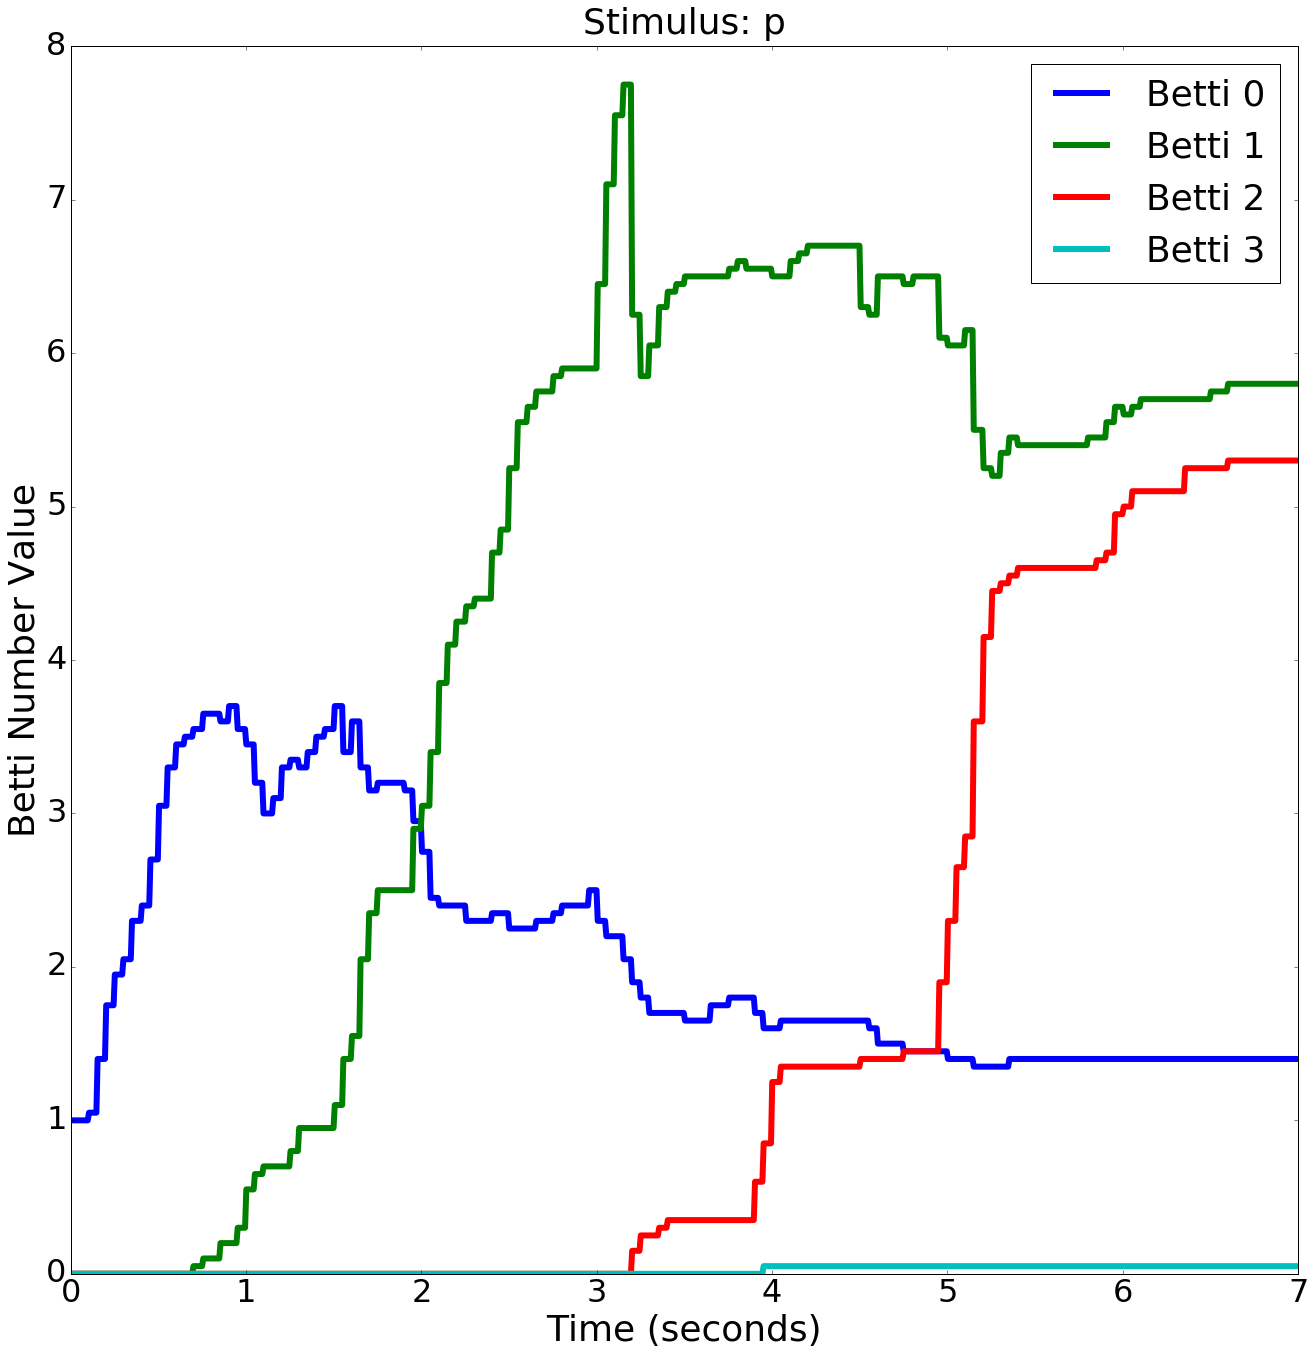

In [22]:
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'36', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'36'}

figsize = (22, 22)
fig = plt.figure(figsize=figsize)

ax = plt.subplot() # Defines ax variable by creating an empty plot

# Set the tick labels font
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(32)

plt.plot(t, avgbetticurve[0, :], t, avgbetticurve[1, :], t, avgbetticurve[2, :], t, avgbetticurve[3, :], lw=6)
plt.title('Stimulus: {}'.format(stimname), **title_font)
plt.xlabel('Time (seconds)', **axis_font)
plt.ylabel('Betti Number Value', **axis_font)
plt.legend(['Betti 0', 'Betti 1', 'Betti 2', 'Betti 3'], fontsize=36)
plt.savefig('/home/brad/B1235_S01P01_StimP_AllBettiAvg.png')

## Plot Average, Gaussian Smoothed PSTHs for each Unit

In [ ]:
bird=1235
windt = 50
prd = 'stim'
pen='02'
site='01'
ntrials = 20
t = np.linspace(0, 7, num=1000)
max_betti=4
betticurves = np.zeros((max_betti, ntrials, 1000))
bettiStimspline=[]
figsize = (11, 11)
figsize = (22, 20)
fig, axs = plt.subplots(4, 4, figsize=figsize)

for stimind in range(16):
    tf = persistence_files[stimind]
    tfilepath, tfilename = os.path.split(tf)
    stimname = list(string.ascii_lowercase)[stimind]
    pdata = pickle.load(open(tf, 'r'))
    ax = axs.flatten()[stimind]
    for trial in range(20):
        
        trialdata = pdata['{}'.format(str(trial))]
        for betti_num in range(max_betti):
            betti1 = np.zeros([len(trialdata), 2])
            for ind, filt in enumerate(trialdata):
                betti1[ind, 0] = filt[0]*windt/1000.
                try: 
                    betti1[ind, 1] = filt[1][betti_num]
                except IndexError:
                    betti1[ind, 1] = 0
                
            bettifunc = interp1d(betti1[:, 0], betti1[:, 1], kind='zero', bounds_error=False, fill_value=(betti1[0, 1], betti1[-1, 1]))
            betticurve = bettifunc(t)
            betticurves[betti_num, trial, :] = betticurve
        
    avgbetticurve = np.mean(betticurves, axis=1)

    ax.plot(t, avgbetticurve[0, :], t, avgbetticurve[1, :], t, avgbetticurve[2, :], t, avgbetticurve[3, :], lw=3)
    ax.set_title('Stimulus: {}'.format(stimname))
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Betti Number Value')
    ax.set_ylim([0, 14])
plt.savefig('/home/brad/B{}_P{}S{}_avgbettis_timedep_{}ms_{}.png'.format(bird, pen, site, windt, prd))

## Plot rasters of each MUA unit

In [37]:
bird=1235
windt = 50
prd = 'prestim'
ntrials = 20
t = np.linspace(0, 7, num=1000)
max_betti=4
betticurves = np.zeros((max_betti, ntrials, 1000))
bettiStimspline=[]


stimind = 13
tf = persistence_files[stimind]
tfilepath, tfilename = os.path.split(tf)
stimname = list(string.ascii_lowercase)[stimind]
pdata = pickle.load(open(tf, 'r'))

for trial in range(20):
        
    trialdata = pdata['{}'.format(str(trial))]
    for betti_num in range(max_betti):
        betti1 = np.zeros([len(trialdata), 2])
        for ind, filt in enumerate(trialdata):
            betti1[ind, 0] = filt[0]*windt/1000.
            try: 
                betti1[ind, 1] = filt[1][betti_num]
            except IndexError:
                betti1[ind, 1] = 0
                
        bettifunc = interp1d(betti1[:, 0], betti1[:, 1], kind='zero', bounds_error=False, fill_value=(betti1[0, 1], betti1[-1, 1]))
        betticurve = bettifunc(t)
        betticurves[betti_num, trial, :] = betticurve
avgbetticurve = np.mean(betticurves, axis=1)


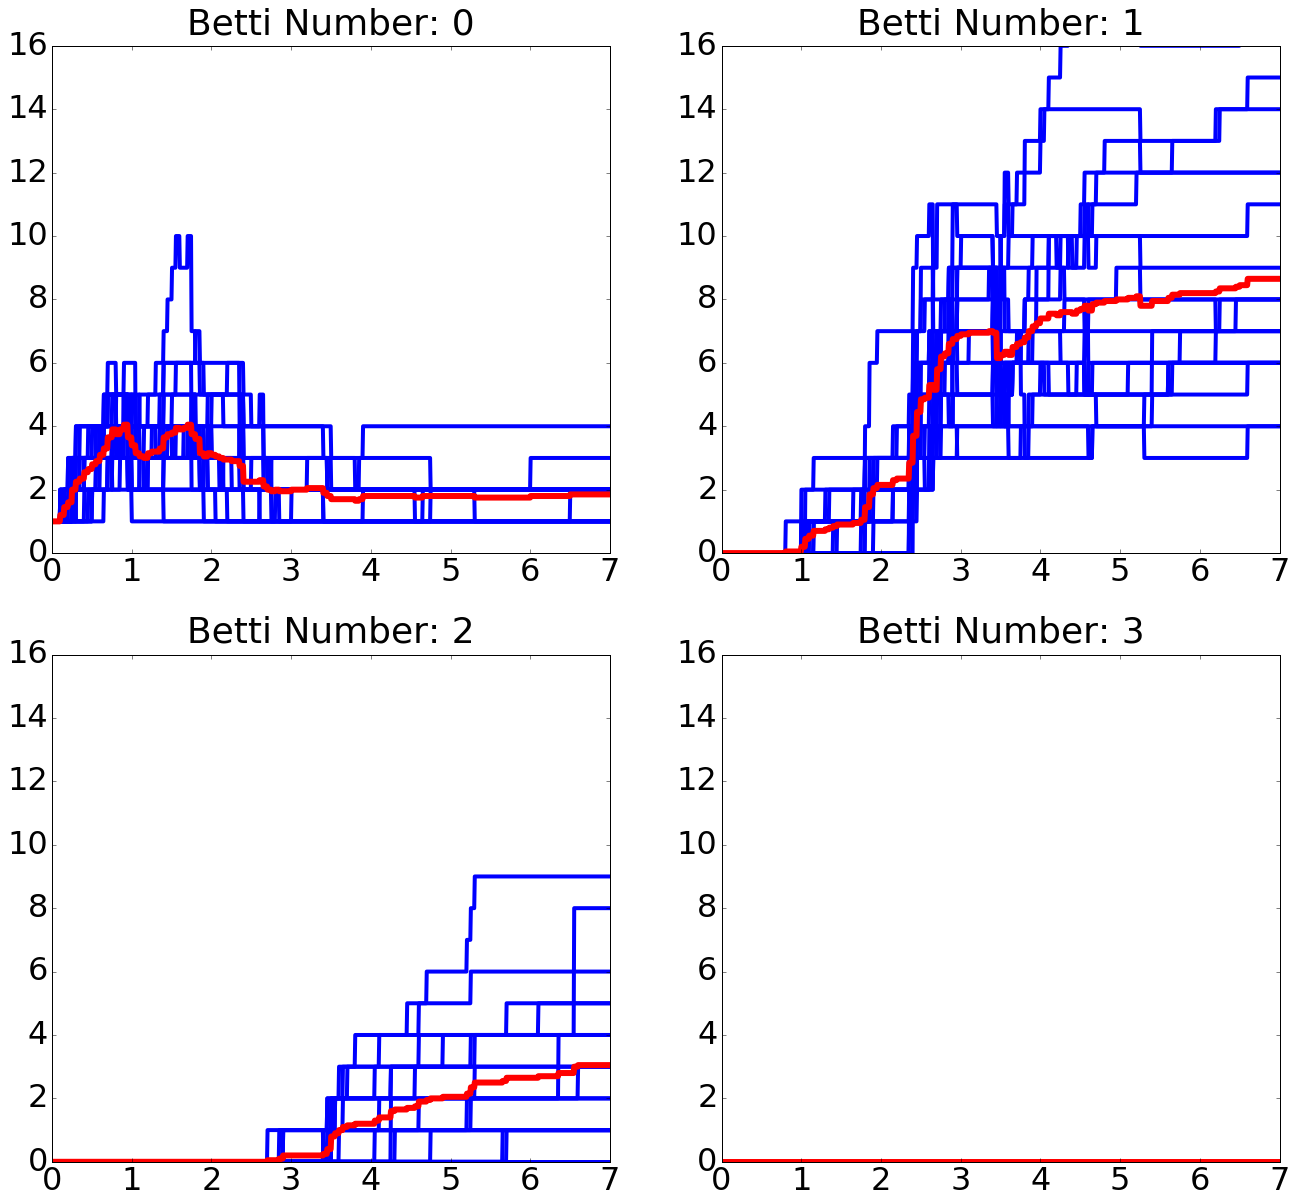

In [38]:
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'36', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'36'}

figsize = (22, 20)
fig, axs = plt.subplots(2, 2, figsize=figsize)

for bettinum in range(max_betti):
    ax = axs.flatten()[bettinum]

    # Set the tick labels font
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(32)
    for trial in range(20):
        ax.plot(t, betticurves[bettinum, trial, :], 'b', lw=4)
        ax.set_title('Betti Number: {}'.format(bettinum), **title_font)
        #ax.set_xlabel('Time (seconds)', **axis_font)
        #ax.set_ylabel('Betti Number Value', **axis_font)
        ax.set_ylim([0, 16])
    ax.plot(t, avgbetticurve[bettinum, :], 'r', lw=6)
plt.savefig('/home/brad/topology_figs/for_neurodinner/B1235_P01S01_Stim13_AllBettis_TrialbyTrial.png')